<a href="https://colab.research.google.com/github/nsatya/CSCI561-2/blob/main/Pranavi_Jalapati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import pickle
import numpy as np
from scipy import signal

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, LSTM, Flatten,concatenate
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/SN/cremad_openface_mfcc.pkl', 'rb') as handle:
    data = pickle.load(handle)

In [ ]:
###### Data pre-processing ######

## Training set    
x_a_train = [] # Acoustic features
x_v_train = [] # Visual features
x_train = [] # Acoustic + Visual features
y_train = [] # Labels

for row in data['train'].values():
  visual_resample = signal.resample(row[1], len(row[0]))
  x_train.append(np.concatenate((row[0], visual_resample), axis=1))
  
  x_a_train.append(row[0])
  x_v_train.append(row[1])
  y_train.append(row[2])   
    
## Validation set    
x_a_val = [] # Acoustic features
x_v_val = [] # Visual features
x_val = [] # Acoustic + Visual features
y_val = [] # Labels

for row in data['val'].values():
  visual_resample = signal.resample(row[1], len(row[0]))
  x_val.append(np.concatenate((row[0], visual_resample), axis=1))

  x_a_val.append(row[0])
  x_v_val.append(row[1])
  y_val.append(row[2])    

## Testing set    
x_a_test = [] # Acoustic features
x_v_test = [] # Visual features
x_test = [] # Acoustic + Visual features
y_test = [] # Labels

for row in data['test'].values():
  visual_resample = signal.resample(row[1], len(row[0]))
  x_test.append(np.concatenate((row[0], visual_resample), axis=1))

  x_a_test.append(row[0])
  x_v_test.append(row[1])
  y_test.append(row[2])  

## Padding the sequence

maxlen = 300

# Acoustic + Visual features
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', dtype='float32')
x_val = pad_sequences(x_val, maxlen=maxlen, padding='post', dtype='float32')    
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post', dtype='float32') 

# Acoustic features
x_a_train = pad_sequences(x_a_train, maxlen=maxlen, padding='post', dtype='float32') 
x_a_val = pad_sequences(x_a_val, maxlen=maxlen, padding='post', dtype='float32') 
x_a_test = pad_sequences(x_a_test, maxlen=maxlen, padding='post', dtype='float32') 

maxlen_v = 85

# Visual features
x_v_train = pad_sequences(x_v_train, maxlen=maxlen_v, padding='post', dtype='float32')
x_v_val = pad_sequences(x_v_val, maxlen=maxlen_v, padding='post', dtype='float32')    
x_v_test = pad_sequences(x_v_test, maxlen=maxlen_v, padding='post', dtype='float32') 

# Labels
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # Accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # Error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

Epoch 1/30
139/139 [==============================] - 21s 123ms/step - loss: 1.7282 - accuracy: 0.2466 - val_loss: 1.6392 - val_accuracy: 0.2889
Epoch 2/30
139/139 [==============================] - 16s 112ms/step - loss: 1.5685 - accuracy: 0.3443 - val_loss: 1.5533 - val_accuracy: 0.3463
Epoch 3/30
139/139 [==============================] - 16s 113ms/step - loss: 1.4679 - accuracy: 0.3948 - val_loss: 1.5340 - val_accuracy: 0.3682
Epoch 4/30
139/139 [==============================] - 16s 113ms/step - loss: 1.4381 - accuracy: 0.4045 - val_loss: 1.5718 - val_accuracy: 0.3634
Epoch 5/30
139/139 [==============================] - 16s 113ms/step - loss: 1.3839 - accuracy: 0.4423 - val_loss: 1.6100 - val_accuracy: 0.3723
Epoch 6/30
139/139 [==============================] - 16s 113ms/step - loss: 1.3549 - accuracy: 0.4412 - val_loss: 1.5539 - val_accuracy: 0.3907
Epoch 7/30
139/139 [==============================] - 16s 115ms/step - loss: 1.2997 - accuracy: 0.4790 - val_loss: 1.5729 - val_ac

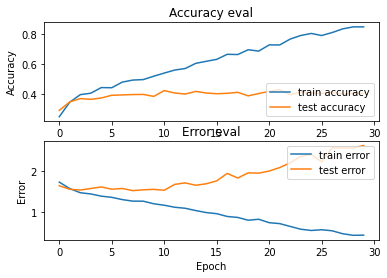

In [ ]:
###### Acoustic model ######

## Model parameters
acoustic_shape = (300, 52)
acoustic_units = 512

## Architecture
acoustic_model = Sequential()

acoustic_model.add(LSTM(acoustic_units, input_shape=acoustic_shape, return_sequences=True))
acoustic_model.add(LSTM(acoustic_units))

acoustic_model.add(Dense(acoustic_units, activation='tanh'))
acoustic_model.add(Dropout(0.2))
#acoustic_model.add(Dense(acoustic_units, activation='tanh'))
acoustic_model.add(Flatten())

acoustic_model.add(Dense(6, activation='softmax'))

## Compile
acoustic_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

## Train
model_run = acoustic_model.fit(x_a_train, y_train, 
                               validation_data=(x_a_val, y_val), 
                               batch_size=32, 
                               epochs=30)

## Plot training metrics
plot_history(model_run)



Results for Acoustic model
Accuracy: 0.42618741976893454
F1 Score: 0.4199707033969973
Confusion Matrix:



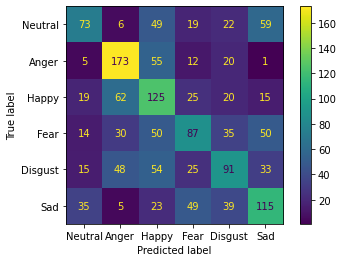

In [ ]:
## Test
y_result = acoustic_model.predict(x_a_test)
y_pred = np.argmax(y_result, axis=1)

## Plot testing metrics
print('Results for Acoustic model')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred, average="macro"))
print('Confusion Matrix:\n')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), 
                              display_labels=['Neutral', 'Anger', 'Happy', 'Fear', 'Disgust', 'Sad'])
disp.plot()


Epoch 1/30
139/139 [==============================] - 8s 24ms/step - loss: 1.4313 - accuracy: 0.4208 - val_loss: 1.2933 - val_accuracy: 0.4665
Epoch 2/30
139/139 [==============================] - 2s 18ms/step - loss: 1.2537 - accuracy: 0.4891 - val_loss: 1.2438 - val_accuracy: 0.4932
Epoch 3/30
139/139 [==============================] - 2s 18ms/step - loss: 1.1856 - accuracy: 0.5244 - val_loss: 1.2216 - val_accuracy: 0.5335
Epoch 4/30
139/139 [==============================] - 2s 18ms/step - loss: 1.1215 - accuracy: 0.5532 - val_loss: 1.1527 - val_accuracy: 0.5444
Epoch 5/30
139/139 [==============================] - 2s 17ms/step - loss: 1.0740 - accuracy: 0.5740 - val_loss: 1.1224 - val_accuracy: 0.5587
Epoch 6/30
139/139 [==============================] - 2s 18ms/step - loss: 1.0301 - accuracy: 0.5934 - val_loss: 1.0989 - val_accuracy: 0.5635
Epoch 7/30
139/139 [==============================] - 3s 18ms/step - loss: 1.0137 - accuracy: 0.6018 - val_loss: 1.0948 - val_accuracy: 0.5635

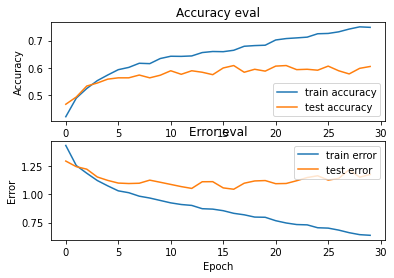

In [ ]:
###### Visual model ######

## Model parameters
visual_shape = (85, 17)
visual_units = 224

## Architecture
visual_model = Sequential()

visual_model.add(LSTM(visual_units, input_shape=visual_shape, return_sequences=True))
visual_model.add(LSTM(visual_units))

visual_model.add(Dense(visual_units, activation='tanh'))
visual_model.add(Dropout(0.2))
visual_model.add(Dense(visual_units/2, activation='tanh'))
visual_model.add(Flatten())

visual_model.add(Dense(6, activation='softmax'))

## Compile
visual_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Train
model_run = visual_model.fit(x_v_train, y_train, 
                             validation_data=(x_v_val, y_val), 
                             batch_size=32, 
                             epochs=30)

## Plot
plot_history(model_run)

Results for Visual model
Accuracy: 0.5725288831835686
F1 Score: 0.5607060806538388
Confusion Matrix:



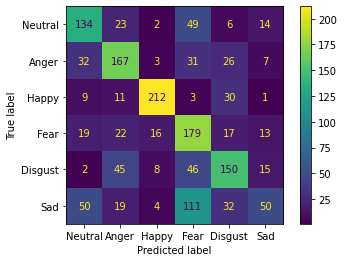

In [ ]:
## Test
y_result = visual_model.predict(x_v_test)
y_pred = np.argmax(y_result, axis=1)

## Plot testing metrics
print('Results for Visual model')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred, average="macro"))
print('Confusion Matrix:\n')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), 
                              display_labels=['Neutral', 'Anger', 'Happy', 'Fear', 'Disgust', 'Sad'])
disp.plot()


In [ ]:
###### Late fusion ######

output_merge = concatenate([acoustic_model.output, visual_model.output])
layer = Dense(6, activation="softmax")(output_merge)

late_fusion_model = Model(inputs=[acoustic_model.input, visual_model.input], outputs=layer)
late_fusion_model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss="sparse_categorical_crossentropy",
                 metrics=['accuracy'])

late_fusion_model.fit(x=[x_a_train, x_v_train], y=y_train, 
             validation_data=([x_a_val, x_v_val], y_val), 
             batch_size=32, 
             epochs=30)

Epoch 1/30
139/139 [==============================] - 27s 150ms/step - loss: 1.5030 - accuracy: 0.4484 - val_loss: 1.6206 - val_accuracy: 0.4092
Epoch 2/30
139/139 [==============================] - 19s 135ms/step - loss: 1.4347 - accuracy: 0.5686 - val_loss: 1.5562 - val_accuracy: 0.4809
Epoch 3/30
139/139 [==============================] - 19s 135ms/step - loss: 1.3657 - accuracy: 0.6532 - val_loss: 1.5406 - val_accuracy: 0.4699
Epoch 4/30
139/139 [==============================] - 19s 135ms/step - loss: 1.3487 - accuracy: 0.6645 - val_loss: 1.5550 - val_accuracy: 0.4699
Epoch 5/30
139/139 [==============================] - 19s 136ms/step - loss: 1.3612 - accuracy: 0.6337 - val_loss: 1.5257 - val_accuracy: 0.5055
Epoch 6/30
139/139 [==============================] - 19s 135ms/step - loss: 1.2935 - accuracy: 0.7188 - val_loss: 1.5117 - val_accuracy: 0.5123
Epoch 7/30
139/139 [==============================] - 19s 136ms/step - loss: 1.2937 - accuracy: 0.6950 - val_loss: 1.4936 - val_ac

Results for early fusion model
Accuracy: 0.5192554557124519
F1 Score: 0.5095412584515661
Confusion Matrix:



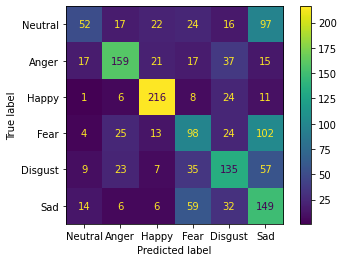

In [ ]:
## Test
y_result = late_fusion_model.predict([x_a_test, x_v_test])
y_pred = np.argmax(y_result, axis=1)

## Plot testing metrics
print('Results for early fusion model')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred, average="macro"))
print('Confusion Matrix:\n')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), 
                              display_labels=['Neutral', 'Anger', 'Happy', 'Fear', 'Disgust', 'Sad'])
disp.plot()

Epoch 1/30
139/139 [==============================] - 20s 120ms/step - loss: 1.4558 - accuracy: 0.4011 - val_loss: 1.2552 - val_accuracy: 0.4720
Epoch 2/30
139/139 [==============================] - 16s 114ms/step - loss: 1.1956 - accuracy: 0.5190 - val_loss: 1.2318 - val_accuracy: 0.5048
Epoch 3/30
139/139 [==============================] - 16s 115ms/step - loss: 1.0850 - accuracy: 0.5805 - val_loss: 1.1409 - val_accuracy: 0.5786
Epoch 4/30
139/139 [==============================] - 16s 113ms/step - loss: 1.0131 - accuracy: 0.6077 - val_loss: 1.0643 - val_accuracy: 0.5984
Epoch 5/30
139/139 [==============================] - 16s 114ms/step - loss: 0.9872 - accuracy: 0.6152 - val_loss: 1.1009 - val_accuracy: 0.5745
Epoch 6/30
139/139 [==============================] - 16s 113ms/step - loss: 0.9167 - accuracy: 0.6473 - val_loss: 1.0949 - val_accuracy: 0.6100
Epoch 7/30
139/139 [==============================] - 16s 115ms/step - loss: 0.8871 - accuracy: 0.6575 - val_loss: 1.1508 - val_ac

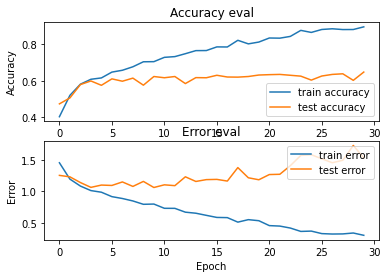

In [ ]:
###### Early fusion model ######

## Model parameters
input_shape = (300, 69)
units = 512

## Architecture
early_fusion_model = Sequential()

early_fusion_model.add(LSTM(units, input_shape=input_shape, return_sequences=True))
early_fusion_model.add(LSTM(units))

early_fusion_model.add(Dense(units, activation='tanh'))
early_fusion_model.add(Dropout(0.2))
#early_fusion_model.add(Dense(acoustic_units, activation='tanh'))
early_fusion_model.add(Flatten())

early_fusion_model.add(Dense(6, activation='softmax'))

## Compile
early_fusion_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

## Train
model_run = early_fusion_model.fit(x_train, y_train, 
                               validation_data=(x_val, y_val), 
                               batch_size=32, 
                               epochs=30)

## Plot training metrics
plot_history(model_run)

Results for Acoustic model
Accuracy: 0.6116816431322208
F1 Score: 0.6139729084174181
Confusion Matrix:



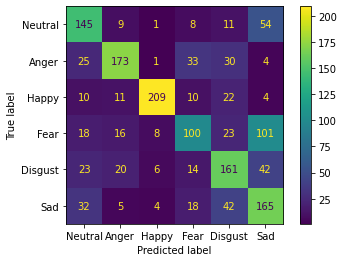

In [ ]:
## Test
y_result = early_fusion_model.predict(x_test)
y_pred = np.argmax(y_result, axis=1)

## Plot testing metrics
print('Results for Acoustic model')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred, average="macro"))
print('Confusion Matrix:\n')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), 
                              display_labels=['Neutral', 'Anger', 'Happy', 'Fear', 'Disgust', 'Sad'])
disp.plot()

#**Assignment Report**

## Question 1

Used LSTM for unimodal classification on acoustic and visual features. 

**Results for acoustic feature classification:**

Accuracy: 0.426

F_1 score: 0.420

Confusion matrix:
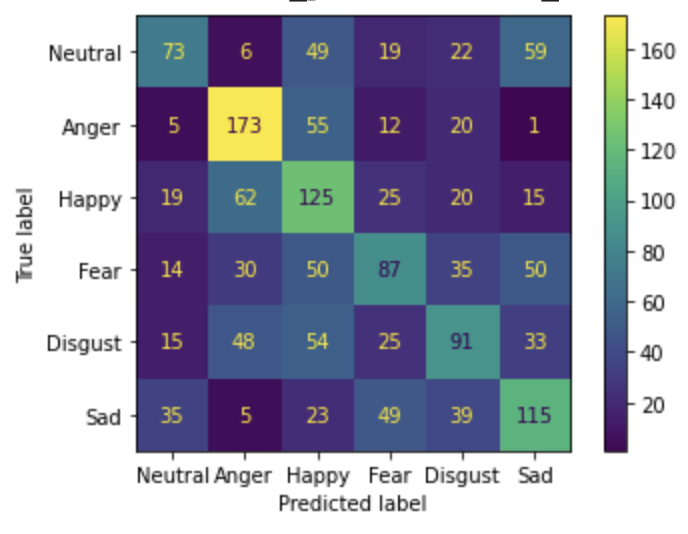

**Results for visual feature classification:**

Accuracy: 0.573

F_1 score: 0.561

Confusion matrix:
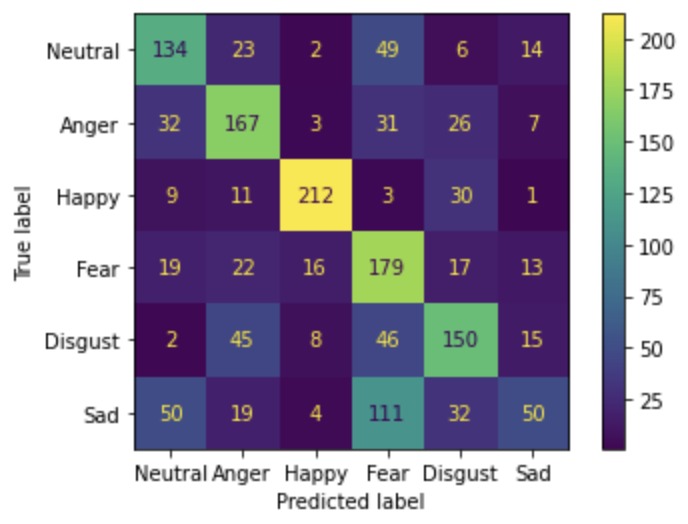

---
## Question 2

Performed late fusion by adding a concatenation layer with softmax activation function.

Accuracy: 0.519

F_1 score: 0.509

Confusion matrix:
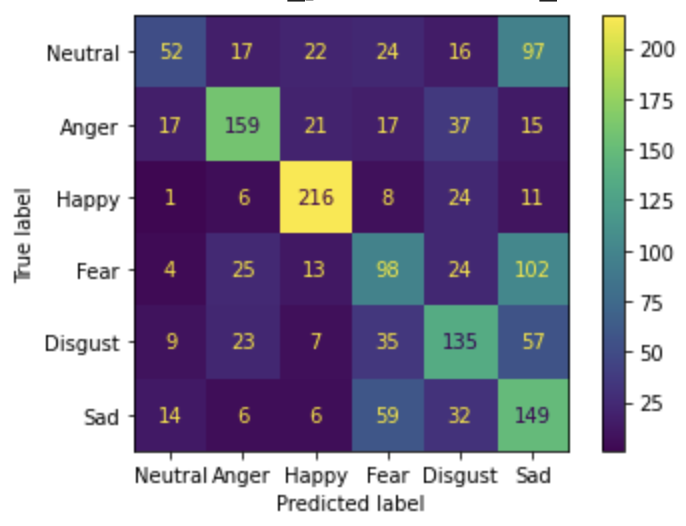

---
## Question 3

Performed early fusion using an LSTM model. The audio and visual features are aligned by upsampling and interpolating the visual features equal to the length of the acoustic features. On aligning the timestamps, the unified feature vector is obtained by concatenating the individual audio and visual features. 

Accuracy: 0.612

F_1 score: 0.614

Confusion matrix:
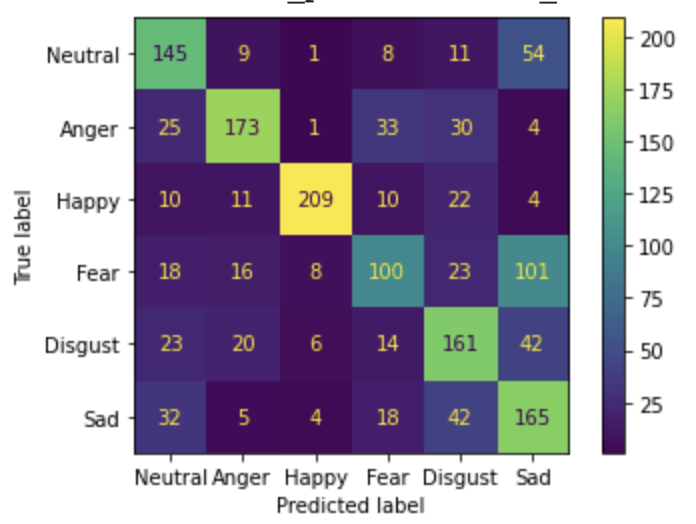

---
## Question 4

* For acoustic features, the overall performance was less than all the other approaches. From the confusion matrix, it can be inferred that the stronger emotions like angry, happy, and sad have a higher accuracy of prediction thatn the other subtle emotions like fear and disgust. 
* For visual features, the overall performance is higher than the acoustic classifier and comparable to the early fusion approach. The confusion matrix for visual features is different from the acoustic classification as the emotions like happy, fear, disgust, and neutral are better classified than sad. Anger still had a higher classifation accuracy like in earlier case. 
* For the late fusion approach, emotions like happy, anger, and sad had high classification accuracy while fear and neutal emotions were mostly misclassified. 
* For early fusion approach, happy and sad emotions have the highest classification accuracies while other emotions had a comparably high accuracy. 
* To  compare the performance for unimodal vs multimodal, similar network architecture has been used for all the approaches. On analysing the results, multimodal classification seems to perform better as compared unimodal classification especially with early fusion. This is evident from the above results. 
* Among unimodal analysis, visual features classified using an additional dense layer has better performance than audio features with the same netwrok architecture. Though reducing the number of dense layers did improve the performance of of the acoustic featuer classification, the overall accuracy was still low. 
* Among early fusion and late fusion, early fusion has significantly better performance than all the other approaches. Given there is no loss of data with upsampling the visual features and they are normalized and interpolated to align with the acoustic features, high accuracy with early fusion indicates a strong correlation among these features. With late fusion approach, this correlation is not captured. From this inference, we can conclude that early fusion approach is better suited for multimodal analysis where the different modalities have strong correlation. 